<h2 style='color:blue' align='center'>Implementation of stochastic and batch grandient descent in python</h2>

#### We will use very simple home prices data set to implement batch and stochastic gradient descent in python. Batch gradient descent uses *all* training samples in forward pass to calculate cumulitive error and than we adjust weights using derivaties. In stochastic GD, we randomly pick *one* training sample, perform forward pass, compute the error and immidiately adjust weights. So the key difference here is that to adjust weights batch GD will use *all* training samples where as stochastic GD will use one randomly picked training sample

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

##### Load the dataset in pandas dataframe

In [2]:
df = pd.read_csv("homeprices_banglore.csv")
df.sample(5)

,area,bedrooms,price
11,2785,4,140.0
13,1100,2,40.0
8,1310,3,50.0
5,1170,2,38.0
14,2250,3,101.0


##### Preprocessing/Scaling: Since our columns are on different sacle it is important to perform scaling on them

In [3]:
from sklearn import preprocessing
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(df.drop('price',axis='columns'))
scaled_y = sy.fit_transform(df['price'].values.reshape(df.shape[0],1))

scaled_X

array([[0.08827586, 0.25      ],
       [0.62068966, 0.75      ],
       [0.22068966, 0.5       ],
       [0.24862069, 0.5       ],
       [0.13793103, 0.25      ],
       [0.12758621, 0.25      ],
       [0.6662069 , 0.75      ],
       [0.86206897, 0.75      ],
       [0.17586207, 0.5       ],
       [1.        , 1.        ],
       [0.34482759, 0.5       ],
       [0.68448276, 0.75      ],
       [0.06896552, 0.25      ],
       [0.10344828, 0.25      ],
       [0.5       , 0.5       ],
       [0.12931034, 0.25      ],
       [0.13103448, 0.5       ],
       [0.25517241, 0.5       ],
       [0.67931034, 0.5       ],
       [0.        , 0.        ]])

In [4]:
scaled_y

array([[0.05237037],
       [0.65185185],
       [0.22222222],
       [0.31851852],
       [0.14074074],
       [0.04444444],
       [0.76296296],
       [0.91111111],
       [0.13333333],
       [1.        ],
       [0.37037037],
       [0.8       ],
       [0.04444444],
       [0.05925926],
       [0.51111111],
       [0.07407407],
       [0.11851852],
       [0.20740741],
       [0.51851852],
       [0.        ]])

##### We should convert target column (i.e. price) into one dimensional array. It has become 2D due to scaling that we did above but now we should change to 1D

In [5]:
scaled_y.reshape(20,)

array([0.05237037, 0.65185185, 0.22222222, 0.31851852, 0.14074074,
       0.04444444, 0.76296296, 0.91111111, 0.13333333, 1.        ,
       0.37037037, 0.8       , 0.04444444, 0.05925926, 0.51111111,
       0.07407407, 0.11851852, 0.20740741, 0.51851852, 0.        ])

##### Gradient descent allows you to find weights (w1,w2,w3) and bias in following linear equation for housing price prediction

<img src="hp.jpg"/>

##### Now is the time to implement mini batch gradient descent. 

In [6]:
def batch_gradient_descent(X, y_true, epochs, learning_rate = 0.01):

    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 2 (area, bedroom)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0] # number of rows in X
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):        
        y_predicted = np.dot(w, X.T) + b

        w_grad = -(2/total_samples)*(X.T.dot(y_true-y_predicted))
        b_grad = -(2/total_samples)*np.sum(y_true-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.mean(np.square(y_true-y_predicted)) # MSE (Mean Squared Error)
        
        if i%10==0:
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w, b, cost, cost_list, epoch_list = batch_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),500)
w, b, cost

(array([0.70712464, 0.67456527]), -0.23034857438407427, 0.0068641890429808105)

###### Check price equation above. In that equation we were trying to find values of w1,w2 and bias. Here we got these values for each of them,
w1 = 0.66469087
w2 = 0.60541671
bias = -0.17792104056392882

###### Now plot epoch vs cost graph to see how cost reduces as number of epoch increases

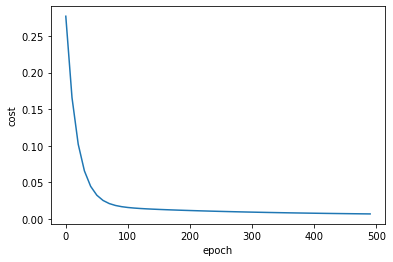

In [7]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list,cost_list)

###### Lets do some predictions now. 

In [8]:
def predict(area,bedrooms,w,b):
    scaled_X = sx.transform([[area, bedrooms]])[0]
    # here w1 = w[0] , w2 = w[1], w3 = w[2] and bias is b
    # equation for price is w1*area + w2*bedrooms + w3*age + bias
    # scaled_X[0] is area
    # scaled_X[1] is bedrooms
    # scaled_X[2] is age
    scaled_price = w[0] * scaled_X[0] + w[1] * scaled_X[1] + b
    # once we get price prediction we need to to rescal it back to original value
    # also since it returns 2D array, to get single value we need to do value[0][0]
    return sy.inverse_transform([[scaled_price]])[0][0]

predict(2600,4,w,b)

128.45484403267596

In [9]:
predict(1000,2,w,b)

30.253094462442355

In [10]:
predict(1500,3,w,b)

69.47860785714694

<h3 style='color:purple'>(2) Stochastic Gradient Descent Implementation</h3>

#### Stochastic GD will use randomly picked single training sample to calculate error and using this error we backpropage to adjust weights

In [11]:
# we will use random libary to pick random training sample.
import random
random.randint(0,6) # randit gives random number between two numbers specified in the argument

1

In [18]:
def stochastic_gradient_descent(X, y_true, epochs, learning_rate = 0.01):
 
    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 3 (area, bedroom and age)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0]
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):    
        random_index = random.randint(0,total_samples-1) # random index from total samples
        sample_x = X[random_index]
        sample_y = y_true[random_index]
        
        y_predicted = np.dot(w, sample_x.T) + b
    
        w_grad = -(2/total_samples)*(sample_x.T.dot(sample_y-y_predicted))
        b_grad = -(2/total_samples)*(sample_y-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.square(sample_y-y_predicted)
        
        if i%100==0: # at every 100th iteration record the cost and epoch value
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w_sgd, b_sgd, cost_sgd, cost_list_sgd, epoch_list_sgd = stochastic_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),10000)
w_sgd, b_sgd, cost_sgd

(array([0.7085746 , 0.67735499]), -0.23102149394250587, 0.009813072123753526)

Compare this with weights and bias that we got using gradient descent. They both of quite similar.

In [19]:
w , b 

(array([0.70712464, 0.67456527]), -0.23034857438407427)

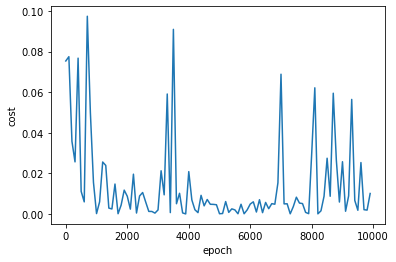

In [20]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list_sgd,cost_list_sgd)

In [21]:
predict(2600,4,w_sgd, b_sgd) 

128.76795544262478

In [22]:
predict(1000,2,w_sgd, b_sgd)

30.26990301568347

In [23]:
predict(1500,3,w_sgd, b_sgd)

69.62331847137968